# Student Performance Bayesian Network

## Load dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 15)

# load dataset
df = pd.read_csv("datasets/student_prediction.csv")
# print number of missing values
print(df.isna().mean().sum())
df

0.0


,STUDENTID,AGE,GENDER,HS_TYPE,SCHOLARSHIP,WORK,ACTIVITY,PARTNER,SALARY,TRANSPORT,...,PREP_STUDY,PREP_EXAM,NOTES,LISTENS,LIKES_DISCUSS,CLASSROOM,CUML_GPA,EXP_GPA,COURSE ID,GRADE
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,1,2,2,1,1,2,2,1,1
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,1,2,3,2,2,1,3,2,1,1
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,2,1,2,2,2,1,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,STUDENT141,2,1,2,3,1,1,2,1,1,...,1,1,2,1,2,1,3,3,9,5
141,STUDENT142,1,1,2,4,2,2,2,1,4,...,1,1,3,2,2,1,5,3,9,5
142,STUDENT143,1,1,1,4,2,2,2,1,1,...,1,1,3,3,2,1,4,3,9,1
143,STUDENT144,2,1,2,4,1,1,1,5,2,...,2,1,2,1,2,1,5,3,9,4


In [3]:
# number of unique values per feature, i.e., the state space
df.nunique()

STUDENTID      145
AGE              3
GENDER           2
HS_TYPE          3
SCHOLARSHIP      5
              ... 
CLASSROOM        3
CUML_GPA         5
EXP_GPA          4
COURSE ID        9
GRADE            8
Length: 33, dtype: int64

## Preprocessing

Preprocessing to combine/aggregate some features, and to divide the dataset into train/test

In [4]:
# Replace GRADE by only 2 values, pass (2) or fail (1) 
df['GRADE'] = np.where(df['GRADE'] > 1, 2, 1)
# Combine the parent's education into single feature COMB_EDU by taking the maximum education
df['COMB_EDU'] = np.amax(np.array([df['MOTHER_EDU'], df['FATHER_EDU']]).T, axis=1)

In [5]:
# listing of old columns and new columns
cols = ['PARTNER', 'WORK', 'ACTIVITY', 'LIVING', 'STUDY_HRS', 'AGE', 'GENDER', 'COMB_EDU', 'PREP_STUDY', 'PREP_EXAM', 'NOTES', 'ATTEND', 'LIKES_DISCUSS', 'GRADE']
new_cols = ['R', 'J', 'E', 'L', 'H', 'A', 'S', 'P', 'ST1', 'ST2', 'T', 'Att', 'D', 'G']

df_renamed = df[cols].rename(columns={x: y for x, y in zip(cols, new_cols)})
df_renamed

,R,J,E,L,H,A,S,P,ST1,ST2,T,Att,D,G
0,2,1,2,1,3,2,2,2,1,1,3,1,1,1
1,2,1,2,1,2,2,2,3,1,1,3,1,3,1
2,2,2,2,2,2,2,2,2,1,1,2,1,1,1
3,1,1,2,2,3,1,1,2,1,2,3,1,2,1
4,1,2,2,4,2,2,2,3,2,1,2,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2,1,1,2,3,2,1,2,1,1,2,1,2,2
141,2,2,2,2,3,1,1,1,1,1,3,2,2,2
142,2,2,2,1,2,1,1,4,1,1,3,1,2,1
143,1,1,1,3,2,2,1,4,2,1,2,1,2,2


## Build model

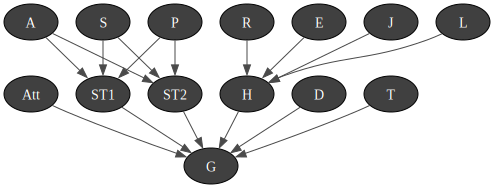

In [6]:
import pyAgrum as gum
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
import pyAgrum.lib.notebook as gnb

bn = gum.BayesNet("Student Performance network")

# Subgraph related to weekly available study hours 
bn.add(gum.LabelizedVariable('R', 'Relationship', ['yes', 'no']))
bn.add(gum.LabelizedVariable('J', 'Additional job', ['yes', 'no']))
bn.add(gum.LabelizedVariable('E', 'Extracurricular activities (sports/arts)', ['yes', 'no']))
bn.add(gum.LabelizedVariable('L', 'Living status', ['rental', 'dormitory', 'with family', 'other']))

bn.add(gum.LabelizedVariable('H','Weekly Study Hours', ['None', '<5 hours', '6-10 hours', '11-20 hours', 'more than 20 hours']))

bn.addArc('R', 'H')
bn.addArc('J', 'H')
bn.addArc('E', 'H')
bn.addArc('L', 'H')

# Subgraph related to nature/nurture
bn.add(gum.LabelizedVariable('A', 'Age', ['18-21', '22-25', 'above 26']))
bn.add(gum.LabelizedVariable('S', 'Sex', ['female', 'male']))
bn.add(gum.LabelizedVariable('P', 'Parents\' education', ['primary school', 'secondary school', 'high school', 'university', 'MSc.', 'Ph.D.']))
bn.add(gum.LabelizedVariable('ST1', 'Study type I', ['alone', 'with friends', 'not applicable']))
bn.add(gum.LabelizedVariable('ST2', 'Study type II', ['last moment', 'regularly', 'never']))

bn.addArcs([(x, y) for x in 'ASP' for y in ['ST1', 'ST2']])

# Combine both subgraphs plus 3 extra nodes
bn.add(gum.LabelizedVariable('T', 'Taking notes', ['never', 'sometimes', 'always']))
bn.add(gum.LabelizedVariable('Att', 'Attendance to class', ['always', 'sometimes', 'never']))
bn.add(gum.LabelizedVariable('D', 'Discussion in class', ['never', 'sometimes', 'always']))

bn.add(gum.LabelizedVariable('G', 'Exam grade', ['fail', 'pass']))

bn.addArc('T', 'G')
bn.addArc('Att', 'G')
bn.addArc('D', 'G')
bn.addArc('ST1', 'G')
bn.addArc('ST2', 'G')
bn.addArc('H', 'G')

gnb.showBN(bn, size=20)

## Compute conditional probability tables

Prior CPT of:
- $p(A) \qquad p(L)$
- $p(S) \qquad p(R)$
- $p(P) \qquad p(Att)$
- $p(E) \qquad p(T)$
- $p(J) \qquad p(D)$

In [7]:
def fillPriorCPT(bn: gum.BayesNet, var: str):
    # determine domain of variable
    domain = [x for x in range(1, bn.variable(var).domainSize()+1)]
    # compute distribution
    distr = df_renamed[var].value_counts(normalize=True).sort_index()
    # in case the distribution is missing probability mass
    zero_vec = pd.Series(np.zeros(len(domain), ), domain)
    distr = (zero_vec + distr).fillna(0)
    # set CPT for variable
    bn.cpt(var).fillWith(distr.to_numpy())


# nodes related to ST1/ST2 subgraph
fillPriorCPT(bn, 'A')
fillPriorCPT(bn, 'S')
fillPriorCPT(bn, 'P')

# nodes related to H subgraph
fillPriorCPT(bn, 'E')
fillPriorCPT(bn, 'J')
fillPriorCPT(bn, 'L')
fillPriorCPT(bn, 'R')

# nodes related to H subgraph
fillPriorCPT(bn, 'Att')
fillPriorCPT(bn, 'T')
fillPriorCPT(bn, 'D')

# show all prior probability tables
gnb.sideBySide(*[bn.cpt(x) for x in 'ASP'], captions=[bn.variable(x).description() for x in 'ASP'])
gnb.sideBySide(*[bn.cpt(x) for x in 'EJLR'], captions=[bn.variable(x).description() for x in 'EJLR'])
irreg_nodes = ['Att', 'T', 'D']
gnb.sideBySide(*[bn.cpt(x) for x in irreg_nodes], captions=[bn.variable(x).description() for x in irreg_nodes])

CPT of $P(ST_1 | A, S, P)$ and $P(ST_2 | A, S, P)$

In [8]:
from itertools import product

age_domain = list(range(1, bn.variable('A').domainSize()+1))
gen_domain = list(range(1, bn.variable('S').domainSize()+1))
edu_domain = list(range(1, bn.variable('P').domainSize()+1))

st1_domainsize = bn.variable('ST1').domainSize()
st2_domainsize = bn.variable('ST2').domainSize()
st1_domain = list(range(1, st1_domainsize+1))
st2_domain = list(range(1, st2_domainsize+1))

rv_info = [
    ('ST1', st1_domain, st1_domainsize), 
    ('ST2', st2_domain, st2_domainsize)]

for ((age_i, age),
     (gen_i, gender),
     (edu_i, par_edu),
     (var_name, dom, dom_size)) in product(enumerate(age_domain), 
                                           enumerate(gen_domain),
                                           enumerate(edu_domain),
                                           rv_info):
    # compute CPT for ST1 and ST2
    conditioned = df_renamed[
        (df_renamed['A'] == age) &
        (df_renamed['S'] == gender) &
        (df_renamed['P'] == par_edu)][var_name].sort_index()
    
    zero_vec = pd.Series(np.zeros(dom_size, ), dom)
    proba = (zero_vec + conditioned.value_counts(normalize=True)).fillna(0)
    
    if 1 - proba.sum() > 0.001:
        uniform_distr = np.ones(dom_size, ) / dom_size
        bn.cpt(var_name)[edu_i, gen_i, age_i, :] = uniform_distr
    else:
        bn.cpt(var_name)[edu_i, gen_i, age_i, :] = proba.to_numpy()


In [9]:
gnb.sideBySide(bn.cpt('ST1'), bn.cpt('ST2'), captions=['Study type I', 'Study type II'])

CPT of $P(H | E, J, L, R)$

In [10]:
act_domain = list(range(1, bn.variable('E').domainSize()+1))
job_domain = list(range(1, bn.variable('J').domainSize()+1))
liv_domain = list(range(1, bn.variable('L').domainSize()+1))
rel_domain = list(range(1, bn.variable('R').domainSize()+1))

hrs_domainsize = bn.variable('H').domainSize()
hrs_domain = list(range(1, hrs_domainsize+1))


for ((liv_i, liv),
     (act_i, act),
     (job_i, job),
     (rel_i, rel)) in product(enumerate(liv_domain), 
                              enumerate(act_domain),
                              enumerate(job_domain),
                              enumerate(rel_domain)):
    # compute CPT for H
    conditioned = df_renamed[
        (df_renamed['L'] == liv) &
        (df_renamed['E'] == act) &
        (df_renamed['J'] == job) & 
        (df_renamed['R'] == rel)]['H'].sort_index()
    
    zero_vec = pd.Series(np.zeros(hrs_domainsize, ), hrs_domain)
    proba = (zero_vec + conditioned.value_counts(normalize=True)).fillna(0)
    
    if 1 - proba.sum() > 0.001:
        uniform_distr = np.ones(hrs_domainsize, ) / hrs_domainsize
        bn.cpt('H')[liv_i, act_i, job_i, rel_i, :] = uniform_distr
    else:
        bn.cpt('H')[liv_i, act_i, job_i, rel_i, :] = proba.to_numpy()


In [11]:
bn.cpt('H')

(pyAgrum.Potential<double>@0x28268610d30) 
                           ||  H                                              |
R     |J     |E     |L     ||None     |<5 hours |6-10 hour|11-20 hou|more than|
------|------|------|------||---------|---------|---------|---------|---------|
yes   |yes   |yes   |rental|| 0.0000  | 0.0000  | 0.0000  | 0.0000  | 1.0000  |
no    |yes   |yes   |rental|| 0.1250  | 0.5000  | 0.1250  | 0.2500  | 0.0000  |
yes   |no    |yes   |rental|| 0.0000  | 0.7500  | 0.2500  | 0.0000  | 0.0000  |
no    |no    |yes   |rental|| 0.1250  | 0.6250  | 0.1250  | 0.1250  | 0.0000  |
yes   |yes   |no    |rental|| 0.3333  | 0.3333  | 0.3333  | 0.0000  | 0.0000  |
no    |yes   |no    |rental|| 0.2000  | 0.2000  | 0.6000  | 0.0000  | 0.0000  |
[...20 more line(s) ...]
yes   |no    |yes   |other || 0.2000  | 0.2000  | 0.2000  | 0.2000  | 0.2000  |
no    |no    |yes   |other || 0.2000  | 0.2000  | 0.2000  | 0.2000  | 0.2000  |
yes   |yes   |no    |other || 0.2000  | 0.2000  | 0.2000  | 0.2000  | 0.2000  |
no    |yes   |no    |other || 0.2000  | 0.2000  | 0.2000  | 0.2000  | 0.2000  |
yes   |no    |no    |other || 0.0000  | 1.0000  | 0.0000  | 0.0000  | 0.0000  |
no    |no    |no    |other || 0.2000  | 0.2000  | 0.2000  | 0.2000  | 0.2000  |

CPT of $p(G | ST_1, ST_2, H, Att, T, D)$

In [12]:
st1_domain = list(range(1, bn.variable('ST1').domainSize()+1))
st1_domain = list(range(1, bn.variable('ST1').domainSize()+1))
hrs_domain = list(range(1, bn.variable('H').domainSize()+1))
att_domain = list(range(1, bn.variable('Att').domainSize()+1))
tno_domain = list(range(1, bn.variable('T').domainSize()+1))
dis_domain = list(range(1, bn.variable('D').domainSize()+1))

grade_domainsize = bn.variable('G').domainSize()
grade_domain = list(range(1, grade_domainsize+1))

for ((hrs_i, hrs),
     (st2_i, st2),
     (st1_i, st1),
     (dis_i, dis),
     (att_i, att),
     (tno_i, tno)) in product(enumerate(hrs_domain), 
                              enumerate(st2_domain), 
                              enumerate(st1_domain), 
                              enumerate(dis_domain),
                              enumerate(att_domain), 
                              enumerate(tno_domain)):
    # compute CPT for G
    conditioned = df_renamed[
        (df_renamed['H'] == hrs) &
        (df_renamed['ST2'] == st2) &
        (df_renamed['ST1'] == st1) & 
        (df_renamed['D'] == dis) & 
        (df_renamed['Att'] == att) & 
        (df_renamed['T'] == tno)]['G'].sort_index()
    
    zero_vec = pd.Series(np.zeros(grade_domainsize, ), grade_domain)
    proba = (zero_vec + conditioned.value_counts(normalize=True)).fillna(0)
    
    if 1 - proba.sum() > 0.001:
        uniform_distr = np.ones(grade_domainsize, ) / grade_domainsize
        bn.cpt('G')[hrs_i, st2_i, st1_i, dis_i, att_i, tno_i, :] = uniform_distr
    else:
        bn.cpt('G')[hrs_i, st2_i, st1_i, dis_i, att_i, tno_i, :] = proba.to_numpy()

In [ ]:
# bn.cpt('G')

## Inference

Prior distribution of the BN

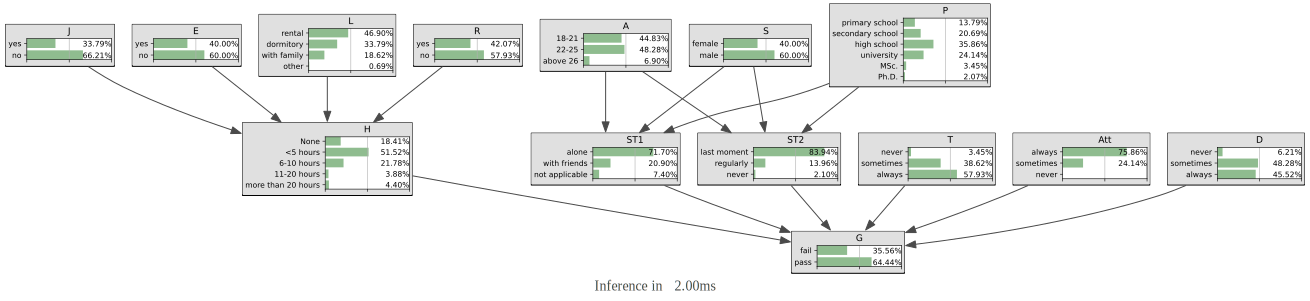

In [14]:
gnb.showInference(bn, evs={}, size='20pt')

Posterior distribution: $p(G | S=\text{male}, R=\text{yes}, J=\text{yes}, T=\text{never})$

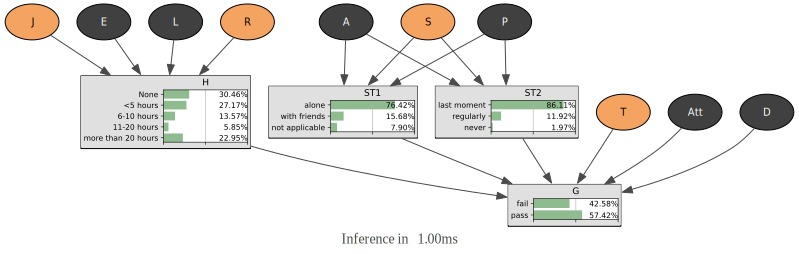

In [15]:
gnb.showInference(bn, evs={'S': 'male', 'R': 'yes', 'T': 'never', 'J': 'yes'}, targets={'H', 'ST1', 'ST2', 'G'}, size='20pt')

## Evaluation

We can use the model as a classifier to predict the likelyhood of passing the course given evidence from a set of students. 
In addition, we can construct a confusion matrix from the model to see how suitable it is for classification tasks. 

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def init_belief_engine(engine):
    # Initialize evidence
    for var in engine.BN().names():
        if var != 'G':
            engine.addEvidence(var, 0)

def predict(bn, engine, row):
    # update belief
    for var in bn.names():
        if var == 'G': continue
        engine.chgEvidence(var, int(row[var]-1))
    engine.makeInference()
    # marginal of p(G)
    y_pred = engine.posterior('G')
    # return p(G=passed)
    return y_pred.toarray()[1]

ie = gum.LazyPropagation(bn)
init_belief_engine(ie)

ys = df_renamed.apply(lambda x: predict(bn, ie, x), axis=1)

cm = confusion_matrix(df_renamed['G']-1, ys.round())
cm = np.around(cm / cm.astype('float').sum(axis=1, keepdims=True), decimals=3)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['failed', 'passed'])

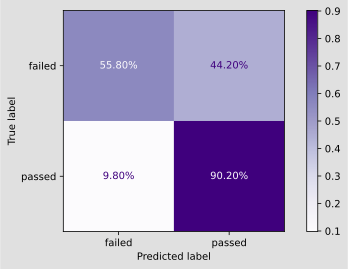

In [17]:
plt.rcParams["figure.figsize"] = (8,4)
disp.plot(cmap=plt.cm.Purples, values_format='.2%')

In [18]:
import pyAgrum.lib.explain as explain

explain.showInformation(bn,{},size="20")

In [19]:
# html = open('entropy.html', 'w')
# html.write(explain.getInformation(bn,{},size="40"))
# html.close()

## Save BN to file

In [40]:
gum.saveBN(bn, "./student_performance_BN.xdsl", True)
# bif|dsl|net|bifxml|o3prm|uai|xdsl

## Generate 1000 samples 

In [41]:
gum.generateSample(bn, 1000, "./datasets/sampled_student_prediction.csv")

-15317.691738584674